# WOHOO Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score
import seaborn as sns


In [2]:
def fnr_per_race(df):
    results = {}
    for race in df['race'].unique():
        sub = df[df['race'] == race]
        fn = np.sum((sub['True_Label'] == 1) & (sub['Predicted_Label'] == 0))
        tp = np.sum((sub['True_Label'] == 1) & (sub['Predicted_Label'] == 1))
        results[race] = fn / (fn + tp + 1e-9)
    return results


In [3]:
def equalized_odds_gap(df):
    races = df['race'].unique()
    fpr = {}
    fnr = {}

    for race in races:
        sub = df[df['race'] == race]

        tn = np.sum((sub['True_Label'] == 0) & (sub['Predicted_Label'] == 0))
        fp = np.sum((sub['True_Label'] == 0) & (sub['Predicted_Label'] == 1))
        fn = np.sum((sub['True_Label'] == 1) & (sub['Predicted_Label'] == 0))
        tp = np.sum((sub['True_Label'] == 1) & (sub['Predicted_Label'] == 1))

        fpr[race] = fp / (fp + tn + 1e-9)
        fnr[race] = fn / (fn + tp + 1e-9)

    fpr_gap = max(fpr.values()) - min(fpr.values())
    fnr_gap = max(fnr.values()) - min(fnr.values())

    return fpr_gap, fnr_gap


In [4]:
def calibration_curve(df, race=None):
    if race:
        df = df[df['race'] == race]

    df['prob_bin'] = pd.cut(df['Prob_Class_1'], bins=np.linspace(0, 1, 11))
    grouped = df.groupby('prob_bin')
    mean_pred = grouped['Prob_Class_1'].mean()
    true_rate = grouped['True_Label'].mean()
    return mean_pred, true_rate


In [5]:
files = {
    "Balanced_LR": "results/balaned_LR.csv",
    "Balanced_RF": "results/balanced_RF.csv",
    "Biased_LR": "results/caucasian_biased_LR.csv",
    "Biased_RF": "results/caucasian_biased_RF.csv",
    "SMOTE_LR": "results/caucasian_smote_LR.csv",
    "SMOTE_RF": "results/caucasian_smote_RF.csv",
    # add Adversarial debiasing when ready:
    # "Adv_LR": "./results/adv_lr.csv",
}


In [6]:
dfs = {name: pd.read_csv(path) for name, path in files.items()}


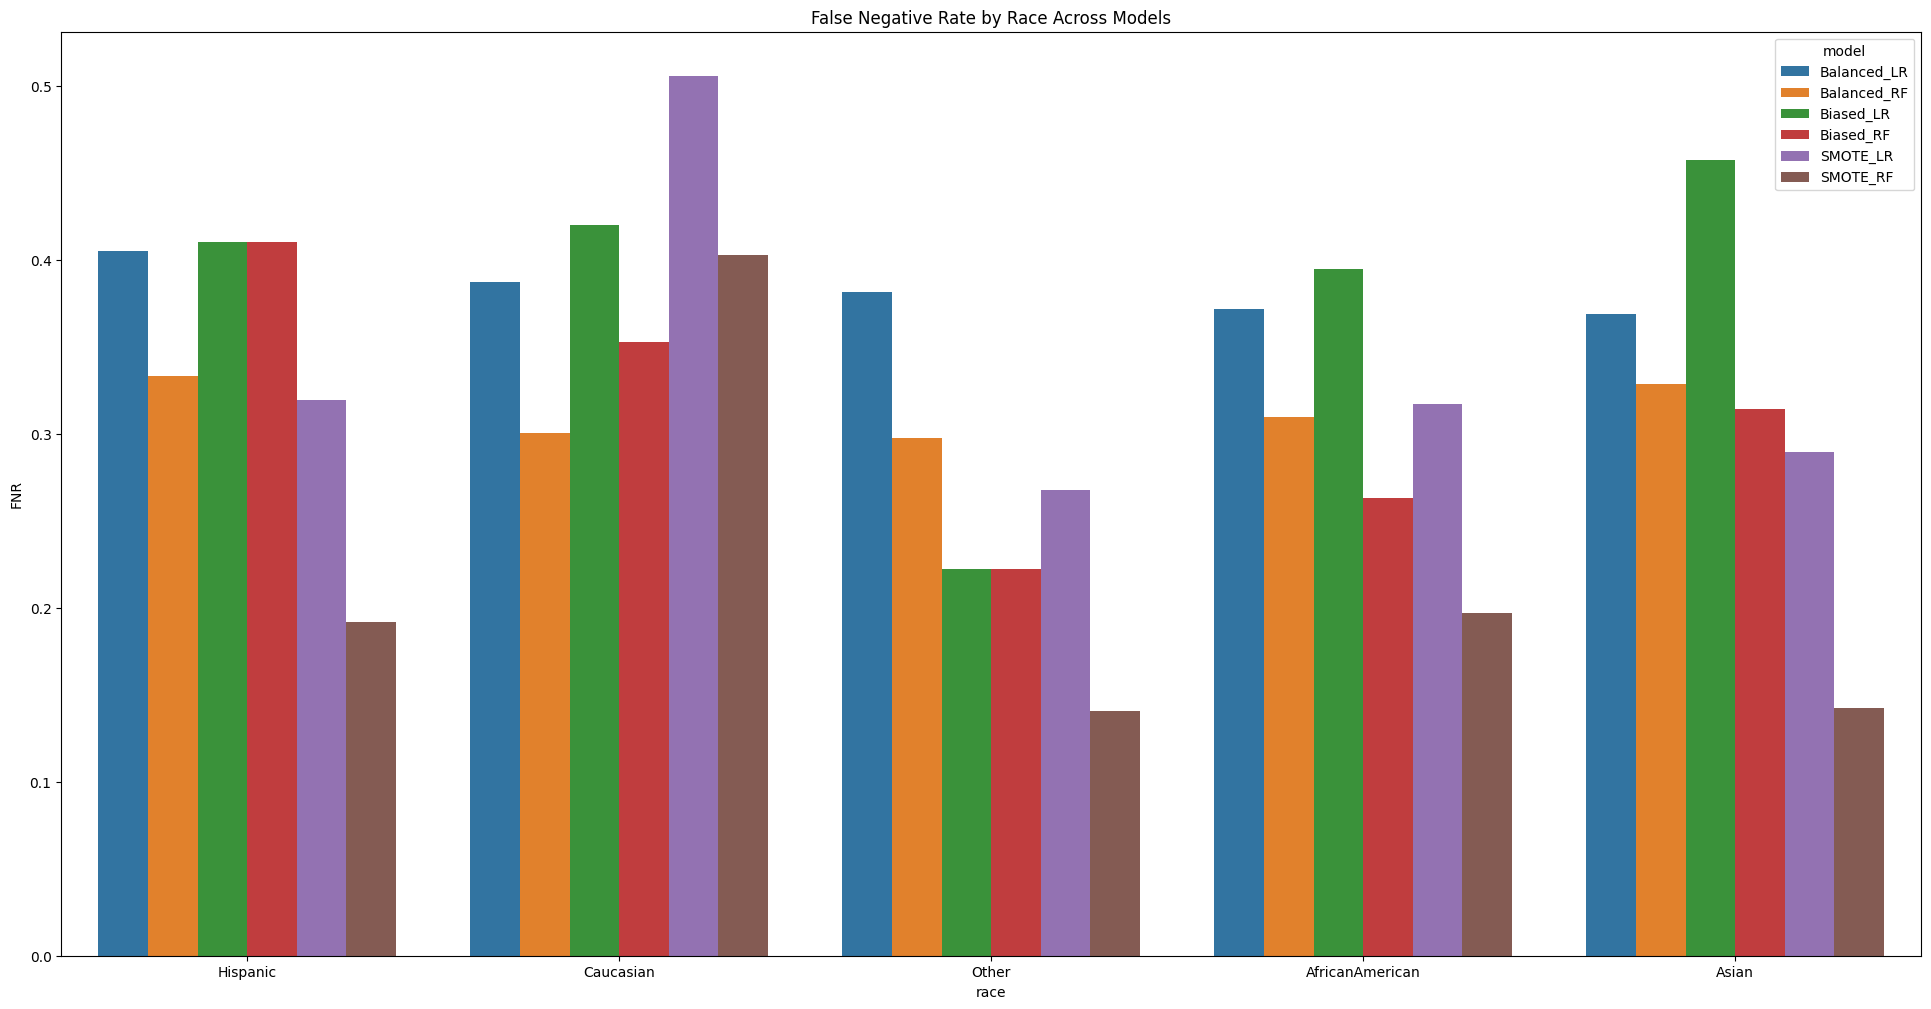

In [20]:
fnr_table = []

for name, df in dfs.items():
    fnrs = fnr_per_race(df)
    for race, value in fnrs.items():
        fnr_table.append({"model": name, "race": race, "FNR": value})

fnr_df = pd.DataFrame(fnr_table)

plt.figure(figsize=(24,12))
sns.barplot(data=fnr_df, x="race", y="FNR", hue="model")
plt.title("False Negative Rate by Race Across Models")
plt.ylabel("FNR")
plt.show()


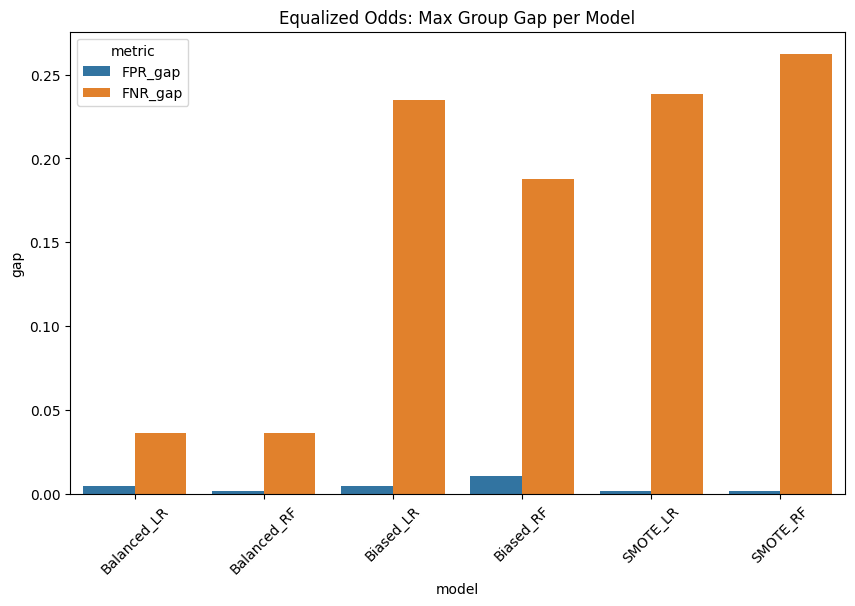

In [8]:
eo_results = []

for name, df in dfs.items():
    fpr_gap, fnr_gap = equalized_odds_gap(df)
    eo_results.append({
        "model": name,
        "FPR_gap": fpr_gap,
        "FNR_gap": fnr_gap
    })

eo_df = pd.DataFrame(eo_results)

eo_df_melted = eo_df.melt(id_vars="model", var_name="metric", value_name="gap")

plt.figure(figsize=(10,6))
sns.barplot(data=eo_df_melted, x="model", y="gap", hue="metric")
plt.xticks(rotation=45)
plt.title("Equalized Odds: Max Group Gap per Model")
plt.show()


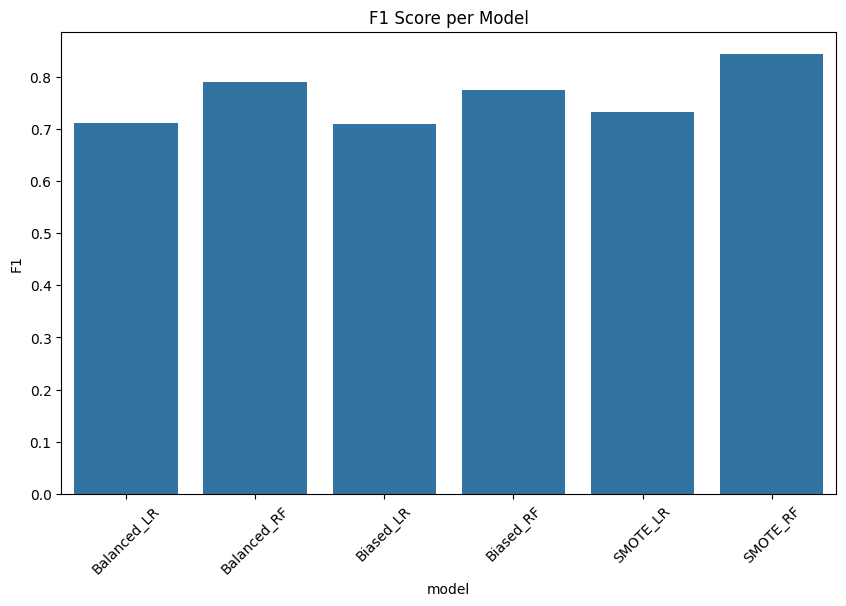

In [10]:
f1_list = []

for name, df in dfs.items():
    f1 = f1_score(df["True_Label"], df["Predicted_Label"])
    f1_list.append({"model": name, "F1": f1})

f1_df = pd.DataFrame(f1_list)

plt.figure(figsize=(10,6))
sns.barplot(data=f1_df, x="model", y="F1")
plt.xticks(rotation=45)
plt.title("F1 Score per Model")
plt.show()


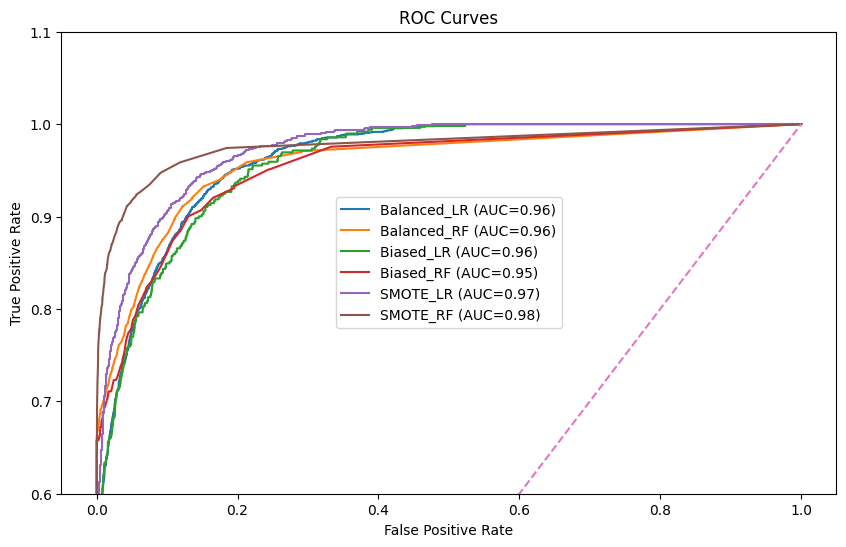

In [19]:
plt.figure(figsize=(10,6))

for name, df in dfs.items():
    fpr, tpr, _ = roc_curve(df["True_Label"], df["Prob_Class_1"])
    auc = roc_auc_score(df["True_Label"], df["Prob_Class_1"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim(0.6, 1.1)
plt.legend()
plt.show()
